# Project No. 1 (סעיף ד) CNN 

### Loading libraries

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score

### Extracting dataset

In [3]:
# Extracting data in DataFrame format
main_path = 'C:\\Users\\dani1\\Documents\\chest_xray'


train_path = os.path.join(main_path,'train')
test_path=os.path.join(main_path,'test')

train_normal = glob.glob(train_path+'\\NORMAL\\*.jpeg')
train_pneumonia = glob.glob(train_path+'\\PNEUMONIA\\*.jpeg')

test_normal = glob.glob(test_path+'\\NORMAL\\*.jpeg')
test_pneumonia = glob.glob(test_path+'\\PNEUMONIA\\*.jpeg')

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]


In [3]:
print(df_train.head())
print(f'Number of pictures in Train dataset: {len(df_train)}')

    class                                              image
0  Normal  C:\Users\dani1\Documents\chest_xray\train\NORM...
1  Normal  C:\Users\dani1\Documents\chest_xray\train\NORM...
2  Normal  C:\Users\dani1\Documents\chest_xray\train\NORM...
3  Normal  C:\Users\dani1\Documents\chest_xray\train\NORM...
4  Normal  C:\Users\dani1\Documents\chest_xray\train\NORM...
Number of pictures in Train dataset: 5216


In [4]:
print(df_test.head())
print(f'Number of pictures in Test dataset: {len(df_test)}')

    class                                              image
0  Normal  C:\Users\dani1\Documents\chest_xray\test\NORMA...
1  Normal  C:\Users\dani1\Documents\chest_xray\test\NORMA...
2  Normal  C:\Users\dani1\Documents\chest_xray\test\NORMA...
3  Normal  C:\Users\dani1\Documents\chest_xray\test\NORMA...
4  Normal  C:\Users\dani1\Documents\chest_xray\test\NORMA...
Number of pictures in Test dataset: 624


### Preproccesing our dataset for CNN

In [5]:
# Splitting train dataframe to train(90%) and validation(10%)
train_df, val_df = train_test_split(df_train, test_size = 0.1, random_state = 42, stratify = df_train['class'])

In [6]:
print(f'Number of pictures in Validation dataset: {len(val_df)}')
print(f'Number of pictures in Train dataset: {len(train_df)}')

Number of pictures in Validation dataset: 522
Number of pictures in Train dataset: 4694


In [7]:
# Preproccesing data
batch_size = 64

train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (224, 224),
                                             class_mode = 'binary',
                                             color_mode = 'grayscale',
                                             batch_size = batch_size,
                                             shuffle=True,
                                             seed = 42)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'grayscale',
                                        batch_size = batch_size,
                                        shuffle=True,
                                        seed = 42)

ds_test = test_datagen.flow_from_dataframe(df_test,
                                        x_col = 'image',
                                        y_col = 'class',
                                        target_size = (224, 224),
                                        class_mode = 'binary',
                                        color_mode = 'grayscale',
                                        batch_size = 1,
                                        shuffle = False)

print(ds_train.image_shape)

Found 4694 validated image filenames belonging to 2 classes.
Found 522 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.
(224, 224, 1)


### Building DNN model and training

In [10]:
# Building model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3),  activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 128)      

In [12]:
epochs = 50 # Run tf.keras.backend.clear_session() in the last cell before running ___.fit

model.compile(loss='binary_crossentropy', optimizer = Adam(learning_rate=1e-5), metrics='accuracy')

history = model.fit(ds_train, batch_size = batch_size, epochs = epochs, validation_data=ds_val)

Epoch 1/50
74/74 [==============================] - 137s 2s/step - loss: 0.6448 - accuracy: 0.7237 - val_loss: 0.5964 - val_accuracy: 0.7433
Epoch 2/50
74/74 [==============================] - 176s 2s/step - loss: 0.5911 - accuracy: 0.7429 - val_loss: 0.5770 - val_accuracy: 0.7433
Epoch 3/50
74/74 [==============================] - 148s 2s/step - loss: 0.5833 - accuracy: 0.7429 - val_loss: 0.5689 - val_accuracy: 0.7433
Epoch 4/50
74/74 [==============================] - 137s 2s/step - loss: 0.5742 - accuracy: 0.7429 - val_loss: 0.5574 - val_accuracy: 0.7433
Epoch 5/50
74/74 [==============================] - 154s 2s/step - loss: 0.5611 - accuracy: 0.7429 - val_loss: 0.5319 - val_accuracy: 0.7433
Epoch 6/50
74/74 [==============================] - 148s 2s/step - loss: 0.5298 - accuracy: 0.7433 - val_loss: 0.4912 - val_accuracy: 0.7433
Epoch 7/50
74/74 [==============================] - 158s 2s/step - loss: 0.4888 - accuracy: 0.7533 - val_loss: 0.4343 - val_accuracy: 0.7548
Epoch 8/50
74

### Evaluating results and model preformance

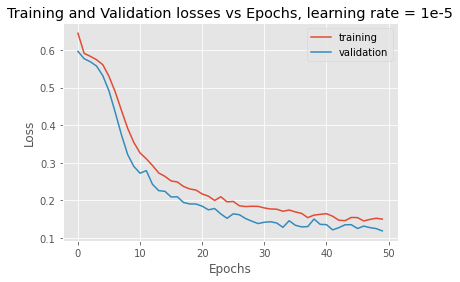

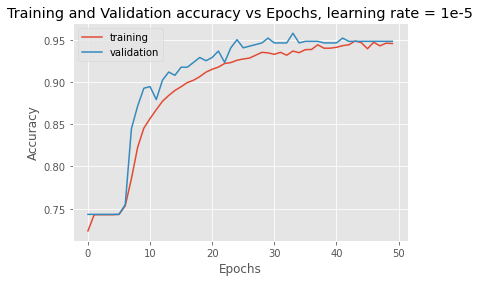

In [31]:
# plot training and validation Loss/Accuracy vs Epochs
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs, learning rate = 1e-5') 
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

In [14]:
model.save('My_CNN3_lr1e-5_batchsize64.h5') # Save model

In [24]:
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test accuracy: {test_accuracy*100}%, Test loss: {test_loss}")

624/624 [==============================] - 7s 11ms/step - loss: 0.5320 - accuracy: 0.8574
Test accuracy: 85.73718070983887%, Test loss: 0.5320330858230591


In [16]:
import seaborn as sns

num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

ds_test.reset()
predictions = model.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels= np.where(predictions>0.5, 1, 0)

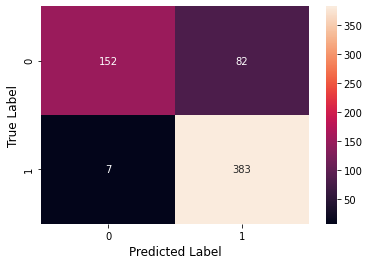

In [21]:
confusion_matrix = confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [29]:
Recall = "{:.2f}".format(recall_score(Y_test, pred_labels))
Precision = "{:.2f}".format(precision_score(Y_test, pred_labels))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.98
Precision score is: 0.82


In [33]:
tf.keras.backend.clear_session() # Run cell before __.fit command